<a href="https://colab.research.google.com/github/tanujpokhriyal2005/Machine-Learning/blob/main/Prediction_of_Landslide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/satellite")

In [ ]:
path_single = r"/content/gdrive/MyDrive/satellite/TrainData/img/image_1610.h5"
path_single_mask = r"/content/gdrive/MyDrive/satellite/TrainData/mask/mask_140.h5"

ls ['img']
input data shape:  (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


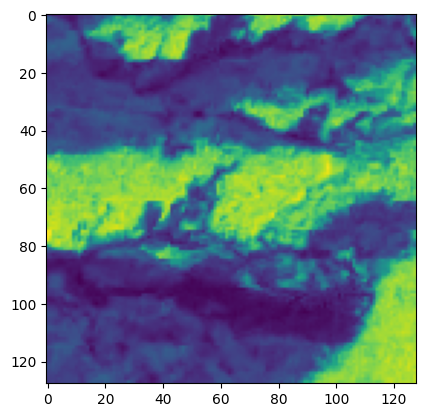

In [ ]:
f_data = np.zeros((1,128,128,3))
with h5py.File(path_single) as hdf:
  ls = list(hdf.keys())
  print("ls",ls)
  data = np.array(hdf.get('img'))
  print("input data shape: ", data.shape)
  plt.imshow(data[:,:,3:0:-1])

  data_red = data[:,:,3]
  data_green = data[:, :, 2]
  data_blue = data[:, :, 1]
  data_nir = data[:, :, 7]
  data_rgb = data[:, :, 3:0:-1]
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
  f_data[0, :, :, 0] =data_ndvi
  f_data[0, :, :, 1] = data[:, :, 12]
  f_data[0, :, :, 2] = data[:, :, 13]

  print('data ndvi shape ', data_ndvi.shape,"f_data shape: ",f_data.shape)
  plt.imshow(data_ndvi)

ls ['mask']
input data shape:  (128, 128)


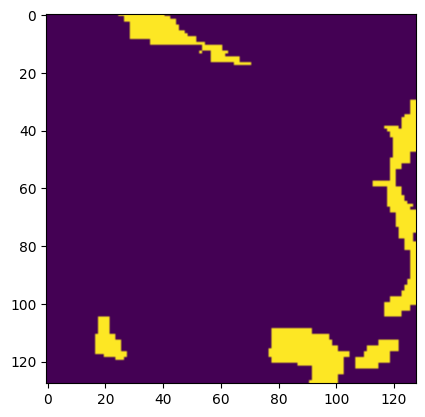

In [ ]:
with h5py.File(path_single_mask) as hdf:
  ls = list(hdf.keys())

  print("ls",ls)
  data = np.array(hdf.get('mask'))
  print("input data shape: ",data.shape)
  plt.imshow(data)

# Using all dataset

In [ ]:
TRAIN_PATH = r"/content/gdrive/MyDrive/satellite/TrainData/img/*.h5"
TRAIN_MASK = r"/content/gdrive/MyDrive/satellite/TrainData/mask/*.h5"


TRAIN_XX =  np.zeros((3799,128,128,6))
TRAIN_YY =  np.zeros((3799,128,128,1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

# Train with RGB,NDVI,DEM and slope

In [ ]:
#testing for google colab GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION


    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

# Testing min,max values in train data

In [ ]:
#TRAIN_XX_N = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(),TRAIN_XX.max(),TRAIN_YY.min(),TRAIN_YY.max())

-1.0 1.0 0.0 1.0


# Custom loss function(dice)

In [ ]:
def dice_loss(Y_true,Y_pred):
  Y_true = tf.cast(Y_true,tf.float32)
  Y_pred = tf.math.sigmoid(Y_pred)
  numerator = 2 * tf.reduce_sum(Y_true * Y_pred)
  denominator = tf.reduce_sum(Y_true + Y_pred)
  return 1 - numerator / denominator

# Visulization of the training data

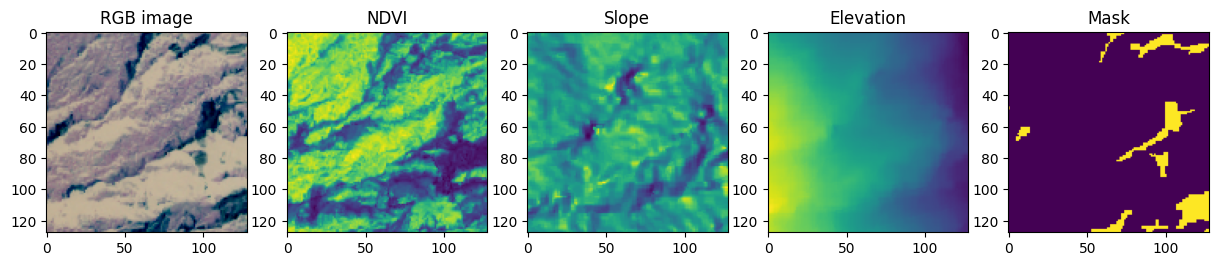

In [ ]:
img = 234
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize = (15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(TRAIN_XX[img,:,:,0:3])
ax2.imshow(TRAIN_XX[img,:,:,3])
ax3.imshow(TRAIN_XX[img,:,:,4])
ax4.imshow(TRAIN_XX[img,:,:,5])
ax5.imshow(TRAIN_YY[img,:,:,0])


# Validation split

In [ ]:
from sklearn.model_selection import train_test_split

#split the data
X_train, X_valid, Y_train, Y_valid = train_test_split(TRAIN_XX,TRAIN_YY,train_size = 0.2,shuffle = True)

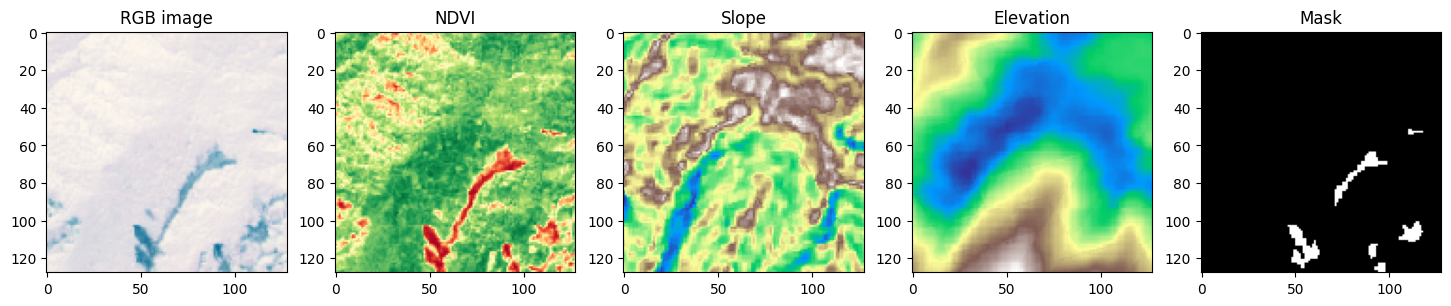

In [ ]:
img = 234
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(18,6))

rgb = X_train[img,:,:,0:3]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

ax1.imshow(rgb)
ax1.set_title("RGB image")

ax2.imshow(X_train[img,:,:,3], cmap='RdYlGn')
ax2.set_title("NDVI")

ax3.imshow(X_train[img,:,:,4], cmap='terrain')
ax3.set_title("Slope")

ax4.imshow(X_train[img,:,:,5], cmap='terrain')
ax4.set_title("Elevation")

ax5.imshow(Y_train[img,:,:,0], cmap='gray')
ax5.set_title("Mask")

plt.show()


In [ ]:
X_train.shape,Y_train.shape

((759, 128, 128, 6), (759, 128, 128, 1))

In [ ]:
#to relese some memory, delete the un-necessary variables
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask

# Unet Model

In [ ]:
import os
print(os.getcwd())       # get current working directory
print(os.listdir())      # list all the files in directory


/content/gdrive/MyDrive/satellite
['TestData', 'TrainData', 'ValidData', '.ipynb_checkpoints', '__pycache__', 'utils.py', 'model_save.h5', 'best_model.h5']


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

In [ ]:
model = unet_model(128, 128, 6)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')

callbacks = [
    # earlyStopping,
    checkpointer
    ]
history = model.fit(X_train, Y_train, batch_size=16,
          epochs=50,
          verbose = 1,
          validation_data=(X_valid, Y_valid),
          callbacks=callbacks)

model.save("model_save.h5")

# Prediction

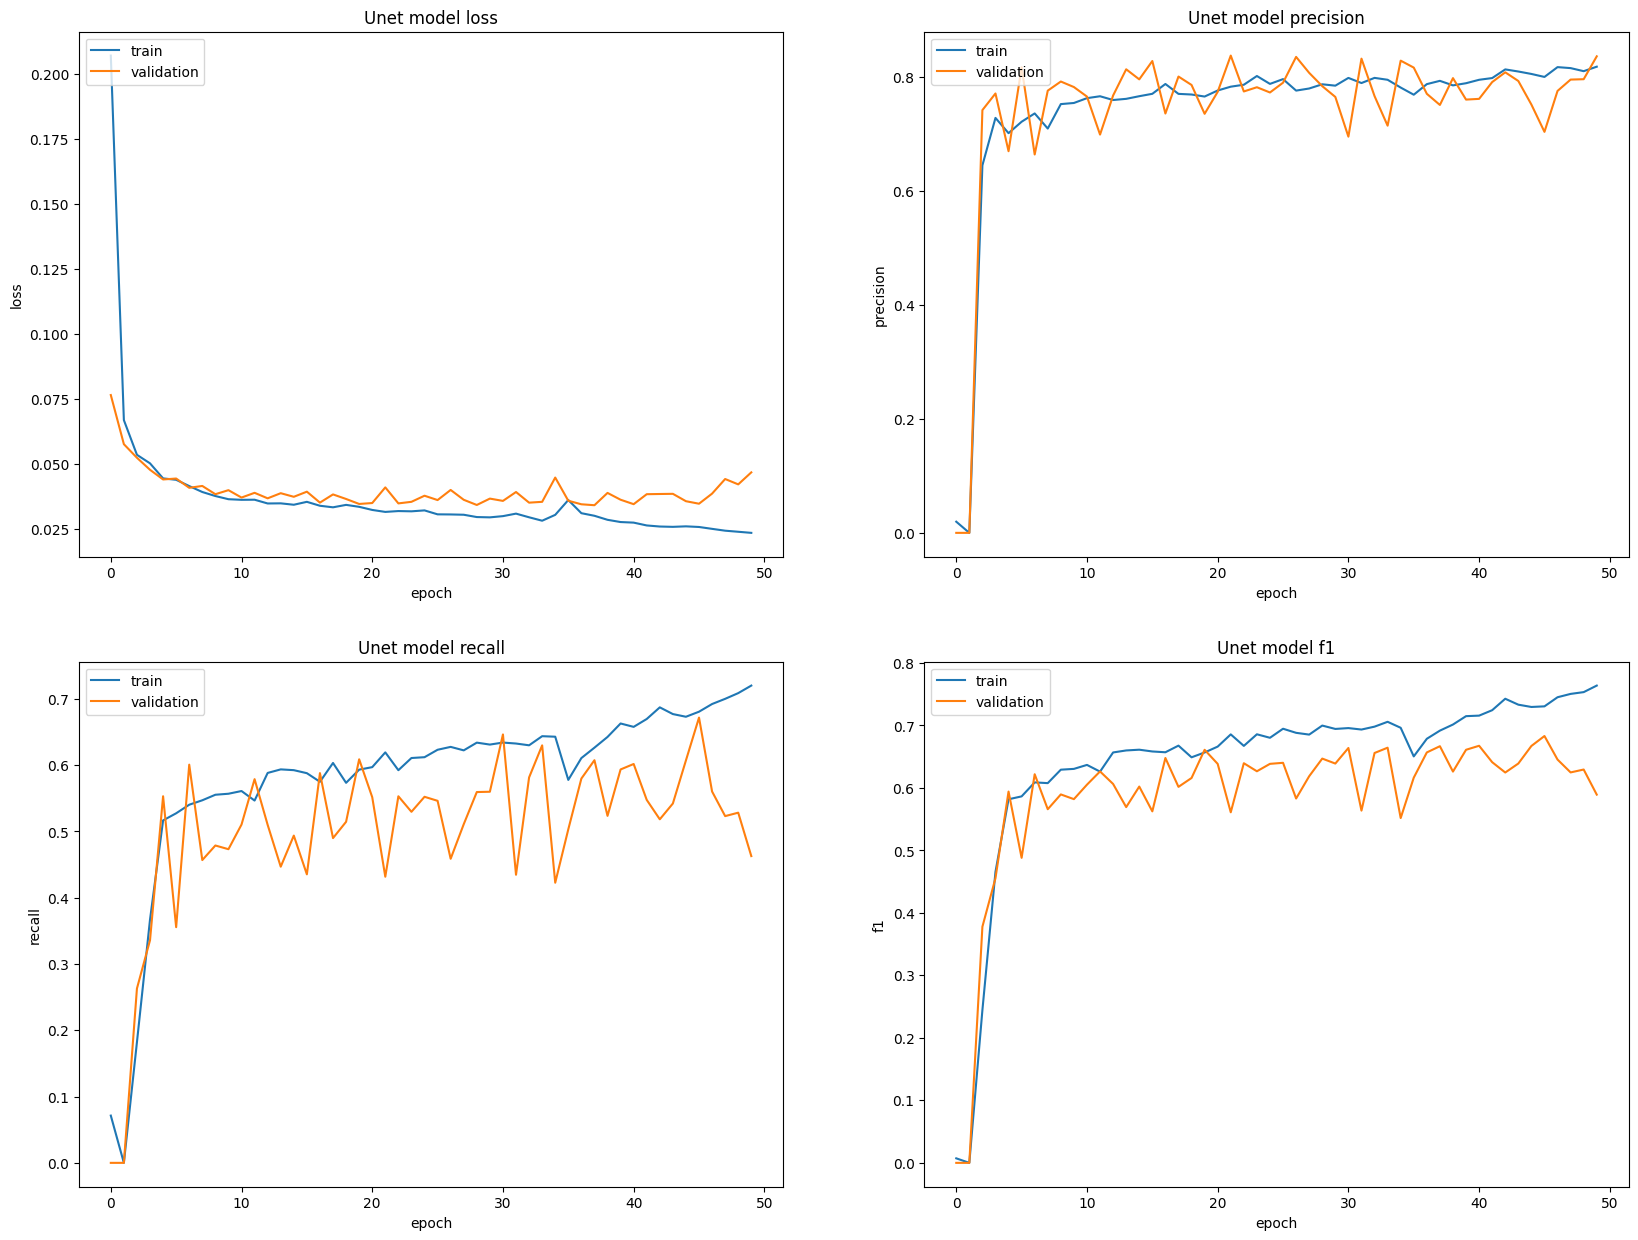

In [ ]:

fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [ ]:

threshold = 0.5
pred_img = model.predict(X_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


Text(0.5, 1.0, 'Training Image')

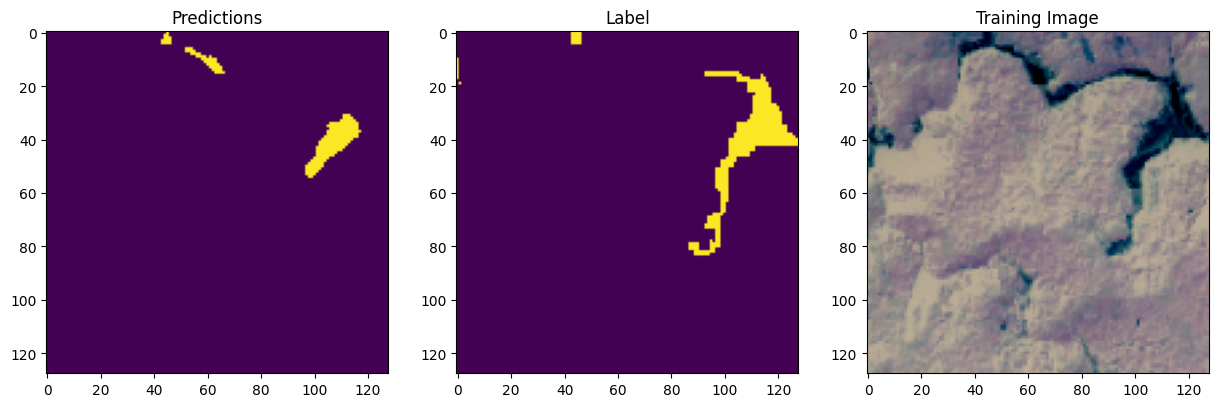

In [ ]:

img = 339
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(Y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(X_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

## Thank You!